In [74]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# библиотека для преобразованя категориальных признаков
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from catboost import CatBoostClassifier, Pool

In [75]:
df = pd.read_csv('DataFrame.csv', sep=',')

In [76]:
df['date_reg'] = pd.to_datetime(df['date_reg'], format="%Y-%m-%d")

In [77]:
df_catf = df.copy()
df_dummy = df.copy()

In [78]:
cat_feat = ['date_reg', 'market', 'group', 'archetype', 'hardware', 'channel', 'dealer', 'phone', 'type_t', 'device']

## Dummy

In [79]:
cat_feat_ = cat_feat.copy()

cat_feat_.remove('date_reg')
cat_feat_.remove('phone')

In [80]:
ohe = OneHotEncoder(sparse=False) 
for j in cat_feat_:
    new_ohe_features = ohe.fit_transform(df_dummy[j].values.reshape(-1, 1))
    tmp = pd.DataFrame(new_ohe_features, columns=[j + '=' + str(i) for i in range(new_ohe_features.shape[1])], dtype='int64')
    df = pd.concat([df_dummy, tmp], axis=1)
    del df_dummy[j]

del df_dummy['phone']

## dummy train - test

In [81]:
X_train_dummy = df_dummy[df_dummy['date_reg'] < '2016-05-13']
X_test_dummy = df_dummy[df_dummy['date_reg'] >= '2016-05-13']

y_train_dummy = X_train_dummy[['client_id', 'churn']]
y_test_dummy = X_test_dummy[['client_id', 'churn']]

del X_train_dummy['churn']
del X_test_dummy['churn']
del X_train_dummy['date_reg']
del X_test_dummy['date_reg']


X_train_dummy = X_train_dummy.set_index('client_id')
y_train_dummy = y_train_dummy.set_index('client_id')
X_test_dummy = X_test_dummy.set_index('client_id')
y_test_dummy = y_test_dummy.set_index('client_id')

## cat feat train - test

In [82]:
X_train_catf = df_catf[df_catf['date_reg'] < '2016-05-13']
X_test_catf = df_catf[df_catf['date_reg'] >= '2016-05-13']

y_train_catf = X_train_catf[['client_id', 'churn']]
y_test_catf = X_test_catf[['client_id', 'churn']]

del X_train_catf['churn']
del X_test_catf['churn']
#del X_train_catf['date_reg']
#del X_test_catf['date_reg']


X_train_catf = X_train_catf.set_index('client_id')
y_train_catf = y_train_catf.set_index('client_id')
X_test_catf = X_test_catf.set_index('client_id')
y_test_catf = y_test_catf.set_index('client_id')

# Cat Boost

## 1. Dummy

In [21]:
%%time
ctb_dummy = CatBoostClassifier()
ctb_dummy.fit(X_train_dummy, y_train_dummy)

Learning rate set to 0.090096
0:	learn: 0.6519315	total: 249ms	remaining: 4m 8s
1:	learn: 0.6187669	total: 309ms	remaining: 2m 33s
2:	learn: 0.5926543	total: 371ms	remaining: 2m 3s
3:	learn: 0.5710892	total: 441ms	remaining: 1m 49s
4:	learn: 0.5531107	total: 520ms	remaining: 1m 43s
5:	learn: 0.5387585	total: 591ms	remaining: 1m 37s
6:	learn: 0.5272269	total: 676ms	remaining: 1m 35s
7:	learn: 0.5175553	total: 738ms	remaining: 1m 31s
8:	learn: 0.5096882	total: 835ms	remaining: 1m 31s
9:	learn: 0.5033575	total: 927ms	remaining: 1m 31s
10:	learn: 0.4981162	total: 1.01s	remaining: 1m 30s
11:	learn: 0.4934879	total: 1.09s	remaining: 1m 29s
12:	learn: 0.4899643	total: 1.17s	remaining: 1m 29s
13:	learn: 0.4867846	total: 1.24s	remaining: 1m 27s
14:	learn: 0.4840446	total: 1.35s	remaining: 1m 28s
15:	learn: 0.4817961	total: 1.44s	remaining: 1m 28s
16:	learn: 0.4799519	total: 1.51s	remaining: 1m 27s
17:	learn: 0.4782908	total: 1.58s	remaining: 1m 26s
18:	learn: 0.4768008	total: 1.66s	remaining: 1

159:	learn: 0.4514892	total: 14s	remaining: 1m 13s
160:	learn: 0.4513905	total: 14s	remaining: 1m 13s
161:	learn: 0.4513192	total: 14.1s	remaining: 1m 12s
162:	learn: 0.4512226	total: 14.2s	remaining: 1m 12s
163:	learn: 0.4511527	total: 14.2s	remaining: 1m 12s
164:	learn: 0.4510421	total: 14.3s	remaining: 1m 12s
165:	learn: 0.4509777	total: 14.4s	remaining: 1m 12s
166:	learn: 0.4509287	total: 14.4s	remaining: 1m 11s
167:	learn: 0.4508616	total: 14.5s	remaining: 1m 11s
168:	learn: 0.4508147	total: 14.5s	remaining: 1m 11s
169:	learn: 0.4507394	total: 14.6s	remaining: 1m 11s
170:	learn: 0.4506633	total: 14.7s	remaining: 1m 11s
171:	learn: 0.4505906	total: 14.8s	remaining: 1m 11s
172:	learn: 0.4505283	total: 14.8s	remaining: 1m 10s
173:	learn: 0.4504268	total: 14.9s	remaining: 1m 10s
174:	learn: 0.4503660	total: 15s	remaining: 1m 10s
175:	learn: 0.4502917	total: 15s	remaining: 1m 10s
176:	learn: 0.4501958	total: 15.1s	remaining: 1m 10s
177:	learn: 0.4501365	total: 15.2s	remaining: 1m 10s
1

318:	learn: 0.4421017	total: 25.6s	remaining: 54.7s
319:	learn: 0.4420371	total: 25.7s	remaining: 54.6s
320:	learn: 0.4419844	total: 25.8s	remaining: 54.5s
321:	learn: 0.4419282	total: 25.8s	remaining: 54.4s
322:	learn: 0.4418803	total: 25.9s	remaining: 54.3s
323:	learn: 0.4418366	total: 26s	remaining: 54.2s
324:	learn: 0.4418100	total: 26s	remaining: 54.1s
325:	learn: 0.4417745	total: 26.1s	remaining: 54s
326:	learn: 0.4417191	total: 26.2s	remaining: 53.9s
327:	learn: 0.4416828	total: 26.3s	remaining: 53.8s
328:	learn: 0.4416306	total: 26.3s	remaining: 53.7s
329:	learn: 0.4415767	total: 26.4s	remaining: 53.6s
330:	learn: 0.4415284	total: 26.5s	remaining: 53.5s
331:	learn: 0.4414771	total: 26.6s	remaining: 53.5s
332:	learn: 0.4414384	total: 26.7s	remaining: 53.5s
333:	learn: 0.4413636	total: 26.8s	remaining: 53.5s
334:	learn: 0.4413212	total: 27s	remaining: 53.5s
335:	learn: 0.4412762	total: 27.1s	remaining: 53.5s
336:	learn: 0.4412128	total: 27.2s	remaining: 53.5s
337:	learn: 0.441151

478:	learn: 0.4349537	total: 39.3s	remaining: 42.8s
479:	learn: 0.4349077	total: 39.4s	remaining: 42.7s
480:	learn: 0.4348792	total: 39.5s	remaining: 42.6s
481:	learn: 0.4348380	total: 39.6s	remaining: 42.5s
482:	learn: 0.4348109	total: 39.6s	remaining: 42.4s
483:	learn: 0.4347817	total: 39.7s	remaining: 42.3s
484:	learn: 0.4347463	total: 39.8s	remaining: 42.3s
485:	learn: 0.4347053	total: 39.9s	remaining: 42.2s
486:	learn: 0.4346685	total: 40s	remaining: 42.1s
487:	learn: 0.4346422	total: 40s	remaining: 42s
488:	learn: 0.4346050	total: 40.1s	remaining: 41.9s
489:	learn: 0.4345495	total: 40.2s	remaining: 41.8s
490:	learn: 0.4345221	total: 40.3s	remaining: 41.7s
491:	learn: 0.4344697	total: 40.3s	remaining: 41.7s
492:	learn: 0.4344403	total: 40.4s	remaining: 41.6s
493:	learn: 0.4344036	total: 40.5s	remaining: 41.5s
494:	learn: 0.4343757	total: 40.6s	remaining: 41.4s
495:	learn: 0.4343419	total: 40.6s	remaining: 41.3s
496:	learn: 0.4342961	total: 40.7s	remaining: 41.2s
497:	learn: 0.4342

639:	learn: 0.4289679	total: 53s	remaining: 29.8s
640:	learn: 0.4289280	total: 53s	remaining: 29.7s
641:	learn: 0.4288945	total: 53.1s	remaining: 29.6s
642:	learn: 0.4288622	total: 53.2s	remaining: 29.5s
643:	learn: 0.4288289	total: 53.3s	remaining: 29.4s
644:	learn: 0.4287960	total: 53.4s	remaining: 29.4s
645:	learn: 0.4287623	total: 53.4s	remaining: 29.3s
646:	learn: 0.4287354	total: 53.5s	remaining: 29.2s
647:	learn: 0.4286971	total: 53.6s	remaining: 29.1s
648:	learn: 0.4286532	total: 53.7s	remaining: 29s
649:	learn: 0.4286091	total: 53.8s	remaining: 28.9s
650:	learn: 0.4285653	total: 53.8s	remaining: 28.9s
651:	learn: 0.4285401	total: 53.9s	remaining: 28.8s
652:	learn: 0.4285016	total: 54s	remaining: 28.7s
653:	learn: 0.4284712	total: 54s	remaining: 28.6s
654:	learn: 0.4284398	total: 54.1s	remaining: 28.5s
655:	learn: 0.4283959	total: 54.2s	remaining: 28.4s
656:	learn: 0.4283689	total: 54.3s	remaining: 28.4s
657:	learn: 0.4283205	total: 54.4s	remaining: 28.3s
658:	learn: 0.4282883	

799:	learn: 0.4234873	total: 1m 5s	remaining: 16.3s
800:	learn: 0.4234678	total: 1m 5s	remaining: 16.2s
801:	learn: 0.4234316	total: 1m 5s	remaining: 16.1s
802:	learn: 0.4234071	total: 1m 5s	remaining: 16.1s
803:	learn: 0.4233699	total: 1m 5s	remaining: 16s
804:	learn: 0.4233451	total: 1m 5s	remaining: 15.9s
805:	learn: 0.4233172	total: 1m 5s	remaining: 15.8s
806:	learn: 0.4232888	total: 1m 5s	remaining: 15.7s
807:	learn: 0.4232617	total: 1m 5s	remaining: 15.6s
808:	learn: 0.4232191	total: 1m 5s	remaining: 15.6s
809:	learn: 0.4231991	total: 1m 5s	remaining: 15.5s
810:	learn: 0.4231708	total: 1m 6s	remaining: 15.4s
811:	learn: 0.4231328	total: 1m 6s	remaining: 15.3s
812:	learn: 0.4231026	total: 1m 6s	remaining: 15.2s
813:	learn: 0.4230727	total: 1m 6s	remaining: 15.1s
814:	learn: 0.4230531	total: 1m 6s	remaining: 15.1s
815:	learn: 0.4230181	total: 1m 6s	remaining: 15s
816:	learn: 0.4229861	total: 1m 6s	remaining: 14.9s
817:	learn: 0.4229577	total: 1m 6s	remaining: 14.8s
818:	learn: 0.42

956:	learn: 0.4186908	total: 1m 17s	remaining: 3.49s
957:	learn: 0.4186452	total: 1m 17s	remaining: 3.41s
958:	learn: 0.4186028	total: 1m 17s	remaining: 3.33s
959:	learn: 0.4185661	total: 1m 17s	remaining: 3.25s
960:	learn: 0.4185358	total: 1m 18s	remaining: 3.17s
961:	learn: 0.4184833	total: 1m 18s	remaining: 3.08s
962:	learn: 0.4184633	total: 1m 18s	remaining: 3s
963:	learn: 0.4184301	total: 1m 18s	remaining: 2.92s
964:	learn: 0.4184060	total: 1m 18s	remaining: 2.84s
965:	learn: 0.4183670	total: 1m 18s	remaining: 2.76s
966:	learn: 0.4183378	total: 1m 18s	remaining: 2.68s
967:	learn: 0.4183028	total: 1m 18s	remaining: 2.6s
968:	learn: 0.4182649	total: 1m 18s	remaining: 2.52s
969:	learn: 0.4182391	total: 1m 18s	remaining: 2.44s
970:	learn: 0.4182079	total: 1m 18s	remaining: 2.36s
971:	learn: 0.4181767	total: 1m 19s	remaining: 2.27s
972:	learn: 0.4181365	total: 1m 19s	remaining: 2.2s
973:	learn: 0.4181134	total: 1m 19s	remaining: 2.12s
974:	learn: 0.4180798	total: 1m 19s	remaining: 2.04

In [22]:
ctb_dummy_valid_pred = ctb_dummy.predict_proba(X_test_dummy)[:,1]

In [23]:
roc_auc_score(y_test_dummy, ctb_dummy_valid_pred)

0.851128594926917

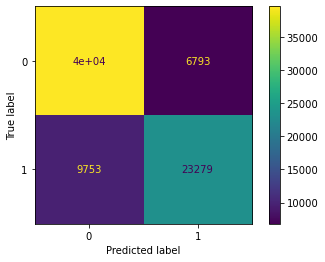

In [27]:
plot_confusion_matrix(ctb_dummy, X_test_dummy, y_test_dummy)
plt.show()

## 2. Cat-feat 

In [83]:
cat_feat

['date_reg',
 'market',
 'group',
 'archetype',
 'hardware',
 'channel',
 'dealer',
 'phone',
 'type_t',
 'device']

In [88]:
cat_feat_inex = list()
for i in cat_feat:
    cat_feat_inex.append(df_catf.columns.get_loc(i))

In [91]:
%%time
ctb_catf = CatBoostClassifier()
ctb_catf.fit(X_train_catf, y_train_catf, cat_features=cat_feat_inex)

Learning rate set to 0.090096
0:	learn: 0.6514680	total: 1.02s	remaining: 16m 58s
1:	learn: 0.6169696	total: 1.41s	remaining: 11m 45s
2:	learn: 0.5890308	total: 1.8s	remaining: 10m
3:	learn: 0.5668589	total: 2.27s	remaining: 9m 24s
4:	learn: 0.5490595	total: 2.81s	remaining: 9m 20s
5:	learn: 0.5337751	total: 3.39s	remaining: 9m 22s
6:	learn: 0.5218735	total: 3.83s	remaining: 9m 2s
7:	learn: 0.5114929	total: 4.3s	remaining: 8m 53s
8:	learn: 0.5025878	total: 4.66s	remaining: 8m 32s
9:	learn: 0.4953998	total: 5.02s	remaining: 8m 17s
10:	learn: 0.4897083	total: 5.43s	remaining: 8m 8s
11:	learn: 0.4843453	total: 5.81s	remaining: 7m 58s
12:	learn: 0.4803244	total: 6.26s	remaining: 7m 55s
13:	learn: 0.4769468	total: 6.77s	remaining: 7m 56s
14:	learn: 0.4742898	total: 7.32s	remaining: 8m
15:	learn: 0.4717730	total: 7.87s	remaining: 8m 4s
16:	learn: 0.4694239	total: 8.26s	remaining: 7m 57s
17:	learn: 0.4676736	total: 8.65s	remaining: 7m 52s
18:	learn: 0.4660181	total: 9.03s	remaining: 7m 46s
19

157:	learn: 0.4382360	total: 1m 12s	remaining: 6m 27s
158:	learn: 0.4381888	total: 1m 13s	remaining: 6m 27s
159:	learn: 0.4380867	total: 1m 13s	remaining: 6m 27s
160:	learn: 0.4380212	total: 1m 14s	remaining: 6m 26s
161:	learn: 0.4379891	total: 1m 14s	remaining: 6m 25s
162:	learn: 0.4379046	total: 1m 14s	remaining: 6m 24s
163:	learn: 0.4378606	total: 1m 15s	remaining: 6m 24s
164:	learn: 0.4378118	total: 1m 15s	remaining: 6m 24s
165:	learn: 0.4377781	total: 1m 16s	remaining: 6m 23s
166:	learn: 0.4377214	total: 1m 16s	remaining: 6m 23s
167:	learn: 0.4376951	total: 1m 17s	remaining: 6m 22s
168:	learn: 0.4376107	total: 1m 17s	remaining: 6m 21s
169:	learn: 0.4375715	total: 1m 18s	remaining: 6m 21s
170:	learn: 0.4375520	total: 1m 18s	remaining: 6m 20s
171:	learn: 0.4374579	total: 1m 18s	remaining: 6m 20s
172:	learn: 0.4374033	total: 1m 19s	remaining: 6m 19s
173:	learn: 0.4373096	total: 1m 19s	remaining: 6m 18s
174:	learn: 0.4372650	total: 1m 20s	remaining: 6m 17s
175:	learn: 0.4371709	total:

310:	learn: 0.4303576	total: 2m 17s	remaining: 5m 4s
311:	learn: 0.4303575	total: 2m 17s	remaining: 5m 3s
312:	learn: 0.4303032	total: 2m 17s	remaining: 5m 2s
313:	learn: 0.4302774	total: 2m 18s	remaining: 5m 2s
314:	learn: 0.4302261	total: 2m 18s	remaining: 5m 1s
315:	learn: 0.4301717	total: 2m 19s	remaining: 5m 1s
316:	learn: 0.4301196	total: 2m 19s	remaining: 5m
317:	learn: 0.4300951	total: 2m 20s	remaining: 5m
318:	learn: 0.4300394	total: 2m 20s	remaining: 4m 59s
319:	learn: 0.4300122	total: 2m 20s	remaining: 4m 59s
320:	learn: 0.4299943	total: 2m 21s	remaining: 4m 58s
321:	learn: 0.4299691	total: 2m 21s	remaining: 4m 58s
322:	learn: 0.4299249	total: 2m 22s	remaining: 4m 57s
323:	learn: 0.4299086	total: 2m 22s	remaining: 4m 57s
324:	learn: 0.4298661	total: 2m 22s	remaining: 4m 56s
325:	learn: 0.4297801	total: 2m 23s	remaining: 4m 56s
326:	learn: 0.4297425	total: 2m 24s	remaining: 4m 56s
327:	learn: 0.4297062	total: 2m 24s	remaining: 4m 56s
328:	learn: 0.4296738	total: 2m 25s	remain

464:	learn: 0.4246942	total: 3m 22s	remaining: 3m 53s
465:	learn: 0.4246589	total: 3m 23s	remaining: 3m 53s
466:	learn: 0.4246019	total: 3m 23s	remaining: 3m 52s
467:	learn: 0.4245543	total: 3m 24s	remaining: 3m 52s
468:	learn: 0.4245377	total: 3m 24s	remaining: 3m 51s
469:	learn: 0.4245123	total: 3m 25s	remaining: 3m 51s
470:	learn: 0.4244923	total: 3m 25s	remaining: 3m 50s
471:	learn: 0.4244491	total: 3m 25s	remaining: 3m 50s
472:	learn: 0.4243981	total: 3m 26s	remaining: 3m 49s
473:	learn: 0.4243759	total: 3m 26s	remaining: 3m 49s
474:	learn: 0.4243556	total: 3m 27s	remaining: 3m 48s
475:	learn: 0.4243304	total: 3m 27s	remaining: 3m 48s
476:	learn: 0.4243024	total: 3m 27s	remaining: 3m 47s
477:	learn: 0.4242650	total: 3m 28s	remaining: 3m 47s
478:	learn: 0.4242333	total: 3m 28s	remaining: 3m 47s
479:	learn: 0.4242151	total: 3m 29s	remaining: 3m 46s
480:	learn: 0.4242009	total: 3m 29s	remaining: 3m 46s
481:	learn: 0.4241757	total: 3m 30s	remaining: 3m 45s
482:	learn: 0.4241416	total:

617:	learn: 0.4199859	total: 4m 27s	remaining: 2m 45s
618:	learn: 0.4199650	total: 4m 28s	remaining: 2m 45s
619:	learn: 0.4199035	total: 4m 28s	remaining: 2m 44s
620:	learn: 0.4198693	total: 4m 28s	remaining: 2m 44s
621:	learn: 0.4198353	total: 4m 29s	remaining: 2m 43s
622:	learn: 0.4198186	total: 4m 29s	remaining: 2m 43s
623:	learn: 0.4198027	total: 4m 30s	remaining: 2m 42s
624:	learn: 0.4197848	total: 4m 30s	remaining: 2m 42s
625:	learn: 0.4197549	total: 4m 30s	remaining: 2m 41s
626:	learn: 0.4197309	total: 4m 31s	remaining: 2m 41s
627:	learn: 0.4197061	total: 4m 31s	remaining: 2m 40s
628:	learn: 0.4196912	total: 4m 32s	remaining: 2m 40s
629:	learn: 0.4196547	total: 4m 32s	remaining: 2m 40s
630:	learn: 0.4196162	total: 4m 32s	remaining: 2m 39s
631:	learn: 0.4196028	total: 4m 33s	remaining: 2m 39s
632:	learn: 0.4195593	total: 4m 33s	remaining: 2m 38s
633:	learn: 0.4195207	total: 4m 34s	remaining: 2m 38s
634:	learn: 0.4194713	total: 4m 34s	remaining: 2m 37s
635:	learn: 0.4194410	total:

770:	learn: 0.4155336	total: 5m 30s	remaining: 1m 38s
771:	learn: 0.4155125	total: 5m 31s	remaining: 1m 37s
772:	learn: 0.4154883	total: 5m 31s	remaining: 1m 37s
773:	learn: 0.4154750	total: 5m 31s	remaining: 1m 36s
774:	learn: 0.4154581	total: 5m 32s	remaining: 1m 36s
775:	learn: 0.4154046	total: 5m 32s	remaining: 1m 36s
776:	learn: 0.4153534	total: 5m 33s	remaining: 1m 35s
777:	learn: 0.4153314	total: 5m 33s	remaining: 1m 35s
778:	learn: 0.4153239	total: 5m 33s	remaining: 1m 34s
779:	learn: 0.4153006	total: 5m 34s	remaining: 1m 34s
780:	learn: 0.4152857	total: 5m 34s	remaining: 1m 33s
781:	learn: 0.4152435	total: 5m 35s	remaining: 1m 33s
782:	learn: 0.4152192	total: 5m 35s	remaining: 1m 32s
783:	learn: 0.4151885	total: 5m 35s	remaining: 1m 32s
784:	learn: 0.4151427	total: 5m 36s	remaining: 1m 32s
785:	learn: 0.4151140	total: 5m 36s	remaining: 1m 31s
786:	learn: 0.4150774	total: 5m 36s	remaining: 1m 31s
787:	learn: 0.4150645	total: 5m 37s	remaining: 1m 30s
788:	learn: 0.4150587	total:

925:	learn: 0.4114163	total: 6m 33s	remaining: 31.4s
926:	learn: 0.4113915	total: 6m 33s	remaining: 31s
927:	learn: 0.4113616	total: 6m 34s	remaining: 30.6s
928:	learn: 0.4113599	total: 6m 34s	remaining: 30.1s
929:	learn: 0.4113332	total: 6m 34s	remaining: 29.7s
930:	learn: 0.4112936	total: 6m 35s	remaining: 29.3s
931:	learn: 0.4112839	total: 6m 35s	remaining: 28.9s
932:	learn: 0.4112774	total: 6m 35s	remaining: 28.4s
933:	learn: 0.4112592	total: 6m 36s	remaining: 28s
934:	learn: 0.4112187	total: 6m 36s	remaining: 27.6s
935:	learn: 0.4112016	total: 6m 37s	remaining: 27.2s
936:	learn: 0.4111683	total: 6m 37s	remaining: 26.7s
937:	learn: 0.4111330	total: 6m 37s	remaining: 26.3s
938:	learn: 0.4111203	total: 6m 38s	remaining: 25.9s
939:	learn: 0.4111104	total: 6m 38s	remaining: 25.4s
940:	learn: 0.4110952	total: 6m 39s	remaining: 25s
941:	learn: 0.4110613	total: 6m 39s	remaining: 24.6s
942:	learn: 0.4110264	total: 6m 39s	remaining: 24.2s
943:	learn: 0.4110099	total: 6m 40s	remaining: 23.8s

In [92]:
ctb_catf_valid_pred = ctb_catf.predict_proba(X_test_catf)[:,1]

In [93]:
roc_auc_score(y_test_catf, ctb_catf_valid_pred)

0.861548995090297

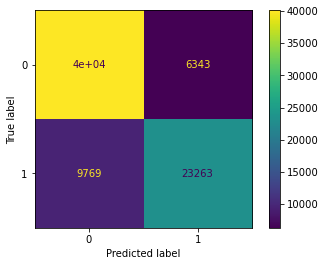

In [94]:
plot_confusion_matrix(ctb_catf, X_test_catf, y_test_catf)
plt.show()